# Learning Curves of Lucie-7B

### 1. Load all benchmark results

Load CSV files ([evaluation_learning_curve_lucie.csv](evaluation_learning_curve_lucie.csv) and [evaluation_baselines.csv](evaluation_baselines.csv)).

In [22]:
# !pip install pandas matplotlib seaborn python-slugify
 
import pandas as pd

lucie_results = pd.read_csv(
    "../evaluation_learning_curve_lucie.csv"
)
baseline_results = pd.read_csv(
    "../evaluation_baselines.csv"
)

# Print some statistics
def unique(field): return len(lucie_results[field].unique())
print(f"✅ {unique('training_tokens')} Lucie checkpoints evaluated on {unique('benchmark')} benchmarks ({unique('dataset')} datasets)")
def unique(field): return len(baseline_results[field].unique())
print(f"✅ {unique('model_name')} baseline checkpoints evaluated on {unique('benchmark')} benchmarks ({unique('dataset')} datasets)")

✅ 36 Lucie checkpoints evaluated on 5 benchmarks (192 datasets)
✅ 9 baseline checkpoints evaluated on 5 benchmarks (184 datasets)


In [23]:
lucie_results = lucie_results[lucie_results['add_bos_token'] == True]
lucie_results = lucie_results[lucie_results['training_phase'].str.contains('3_annealing-5B-mix6|main', regex=True)]

### 2. Setup a plot config (and some normalization of model/dataset names)

In the code cell below, `benchmarks` must be a dictionary:
* key: the name of the benchmark (will be plotted as a title)
* values: a list of dataset names that will be plotted together (see column `dataset` of [the CSV file](evaluation_learning_curve_lucie.csv))


In [24]:
# What to plot
BENCHMARKS = {
    "benchmarks in English":
        [
            "arc_challenge",        "hellaswag",
            "mmlu",
            "mmlu_continuation",    "winogrande",
            "gsm8k",                "truthfulqa_mc2",
        ],
    "French Bench":
        [
            "french_bench_arc_challenge",   "french_bench_hellaswag",
            "french_bench_grammar",         "french_bench_vocab",
        ],
    "French Bench Generative":
        [
            "french_bench_fquadv2_genq",   "french_bench_multifquad",
            "french_bench_orangesum_abstract",         "french_bench_trivia",
        ],
    "Multilingual ARC benchmark":
        [
            "arc_fr",   "arc_es",
            "arc_de",   "arc_it",
        ],
}

# Output folder to save figures
OUTPUT_FOLDER = "../figs"


PLOT_FIRST_PRETRAINING = False

# Some niceties to normalize dataset names
def normalize_dataset_name(name):
    words = []
    _languages = {
        "fr": "French",
        "es": "Spanish",
        "de": "German",
        "it": "Italian",
        "en": "English",
    }
    for w in name.split("_"):
        if w in _languages:
            w = _languages[w]
        elif len(w) <= 2 or w in ["arc", "mmlu", "mmmlu", "mc2", "mc1"]:
            w = w.upper()
        else:
            w = w.replace("gsm", "GSM")
            w = w[0].upper() + w[1:]
        words.append(w)
    return " ".join(words)
    

# Some niceties to normalize baseline names
def normalize_baseline_name(name):
    common = normalize_baseline_name_no_version(name)
    if "instruct" in name.lower():
        return common + "-Instruct"
    if "Chat" in name:
        return common + "-Chat"
    if "annealing" in name.lower():
        return common + "-Annealing"
    return common

def normalize_baseline_name_no_version(name):
    name = name.replace("__", "/").split("/")[-1]
    for common in ["Bloom", "Croissant", "Pythia-6.9B", "Llama-3", "Mistral-7B", "Falcon-7B"]:
        if common.lower() in name.lower():
            return common
    return name

def key_order_model_name(name):
    nlower = name.lower()
    if "lucie" in nlower:
        return (0, name)
    if "falcon" in nlower or "pythia" in nlower:
        return (3, name)
    if "croissant" in nlower:
        return (2, name)
    return (1, name)
    


### 3. Plot the learning curves

Saving figs/learning-curve-evaluation-benchmarks-in-english.png...


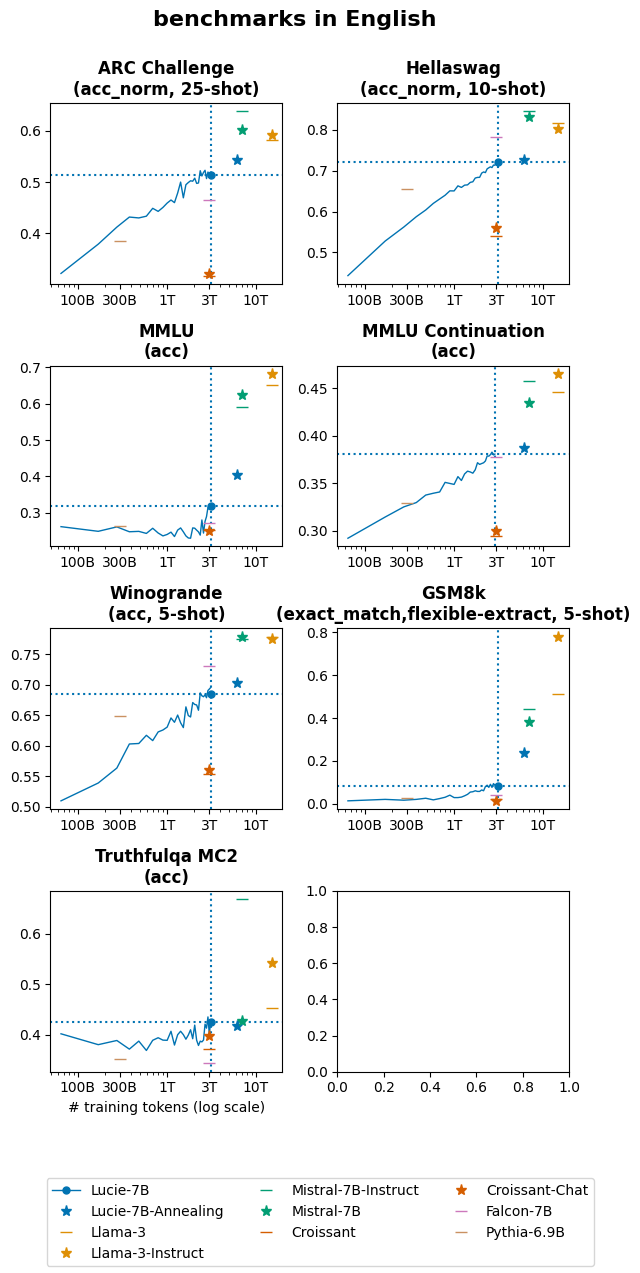

Saving figs/learning-curve-evaluation-french-bench.png...


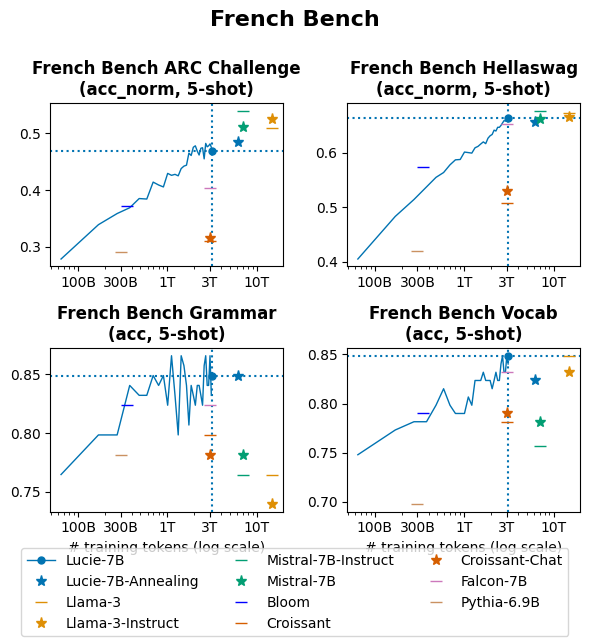

Saving figs/learning-curve-evaluation-french-bench-generative.png...


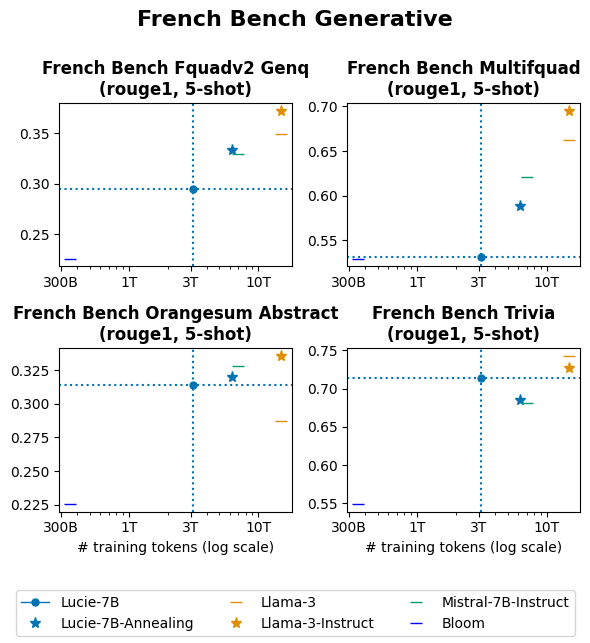

Saving figs/learning-curve-evaluation-multilingual-arc-benchmark.png...


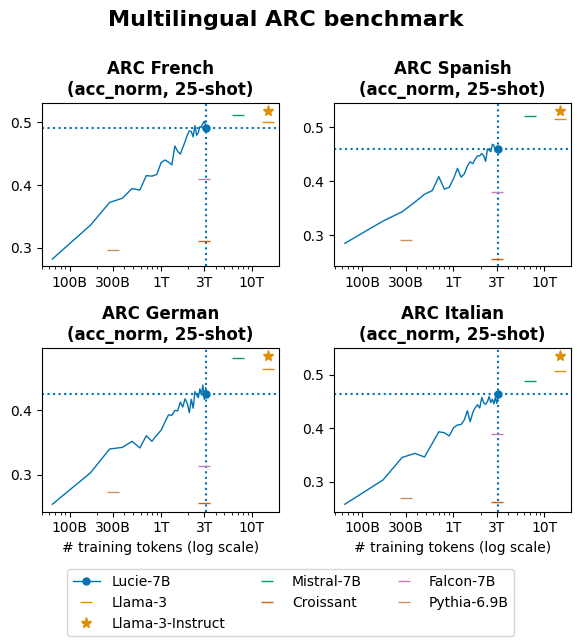

In [25]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import slugify


PLOT_FIRST_PRETRAINING = True
PLOT_INSTRUCT = True
PLOT_ANNEALING = True

def plot_learning_curve(
        lucie_results,
        baseline_results,
        xlabel=True,
        xlogscale=True,
        use_lines=True,
        title=None,
    ):
    global _cached_baseline_indices
    if "_cached_baseline_indices" not in globals():
        _cached_baseline_indices = {}

    threshold_no_pretraining = 3_121_742_086_100

    if not PLOT_FIRST_PRETRAINING:
        lucie_results = lucie_results[lucie_results["training_tokens"] > threshold_no_pretraining]
        baseline_results = baseline_results[baseline_results["training_tokens"] > threshold_no_pretraining]

    if not PLOT_INSTRUCT:
        lucie_results = lucie_results[~lucie_results["model_name"].str.contains("Instruct")]
        baseline_results = baseline_results[~baseline_results["model_name"].str.contains("Instruct")]

    if not PLOT_ANNEALING:
        lucie_results = lucie_results[~lucie_results["model_name"].str.contains("Annealing")]

    # Set colorblind-friendly color palette
    color_palette = sns.color_palette("colorblind", n_colors=6)  # Colorblind-friendly palette
    lucie_color = color_palette[0]
    baseline_colors = color_palette[1:] + ['blue']
    baseline_markers = ['_', '*', 's', '^', 'D', 'v', '*', 'o']  # Circle, Square, Diamond, Down-Triangle, Up-Triangle, Circle again
    baseline_markersizes = [8] * len(baseline_markers) # [6, 6, 6, 6, 6, 6, 6]  # Adjust sizes for each marker type
    norm_tokens = 1e09 if not xlogscale else 1
    score_name = num_fewshot = None

    baseline_names = sorted(baseline_results["model_name"].unique(), key=key_order_model_name)
    norm_baseline_names = [normalize_baseline_name_no_version(name) for name in baseline_names]
    has_several_versions = len(set(norm_baseline_names)) != len(norm_baseline_names)

    if not len(lucie_results):
        baseline_names = norm_baseline_names = []

    if len(lucie_results):

        score_name = set(lucie_results["score_name"])
        assert len(score_name) == 1, f"Multiple score names found: {score_name}"
        score_name = list(score_name)[0]
        score_name = score_name.replace(",none", "")

        num_fewshot = set(lucie_results["num_fewshot"])
        num_fewshot = list(num_fewshot)[0]
        if num_fewshot:
            try:
                num_fewshot = int(num_fewshot)
            except Exception:
                num_fewshot = None
        
        # Lucie
        for i, model_name in enumerate(lucie_results["model_name"].unique()):

            name_no_version = normalize_baseline_name_no_version(model_name)
            name = normalize_baseline_name(model_name)

            results = lucie_results[lucie_results["model_name"] == model_name] \
                .sort_values(by=["training_tokens", "score"], ascending=True)
            
            is_main = (name == name_no_version)

            # Vertical and horizontal lines for the last point
            if is_main:
                last_x = list(results['training_tokens'])[-1] / norm_tokens
                last_perf = list(results['score'])[-1]
                if use_lines:
                    plt.axvline(x=last_x / norm_tokens, color=lucie_color, linestyle=':')  # Add vertical line
                    plt.axhline(y=last_perf, color=lucie_color, linestyle=':')  # Add horizontal line
                else:
                    plt.plot([last_x], [last_perf], "+", markersize=10, color=lucie_color)

            if is_main:
                assert i == 0, f"Multiple main models found, mapping to {name_no_version} (<- {name} <- {model_name})"
                marker = 'o-'
                markersize = 5

                first_learning_points = results[results["training_tokens"] <= threshold_no_pretraining]
                results = results[results["training_tokens"] > threshold_no_pretraining]
                plt.plot(
                    first_learning_points['training_tokens'] / norm_tokens,
                    first_learning_points['score'],
                    label=model_name if not len(results) else None,
                    color=lucie_color,
                    linewidth=1
                )

            else:
                has_several_versions = True
                idx_marker = i-1
                marker = baseline_markers[idx_marker]
                if 'Annealing' in model_name:
                    marker = '*'
                markersize = baseline_markersizes[idx_marker]

            if len(results):
                plt.plot(
                    results['training_tokens'] / norm_tokens,
                    results['score'],
                    marker,
                    markersize=markersize,
                    label=model_name,
                    color=lucie_color,
                    linewidth=1
                )

    if xlogscale and len(lucie_results):
        plt.xscale('log')  # Set x-axis to log scale
        xticks_coordinates, _ = plt.xticks()
        previous = xticks_coordinates[0]
        new_xticks = [previous]
        for x in xticks_coordinates[1:]:
            if x / previous >= 10 - 1e-06:
                new_xticks.append(3 * previous)
            new_xticks.append(x)
            previous = x
        if norm_tokens == 1:
            new_xticks_labels = [format_big_integer(x) for x in new_xticks]
            plt.xticks(new_xticks, new_xticks_labels)
        else:
            plt.xticks(new_xticks)

    # Baselines with different colors, shapes, and adjusted marker sizes
    current_version_idx = {}
    for model_name in baseline_names:
        results = baseline_results[baseline_results["model_name"] == model_name]
        name_no_version = normalize_baseline_name_no_version(model_name)
        name = normalize_baseline_name(model_name)
        if name_no_version in _cached_baseline_indices:
            idx = _cached_baseline_indices[name_no_version]
        else:
            idx = _cached_baseline_indices[name_no_version] = len(_cached_baseline_indices)
        if idx >= len(baseline_colors):
            raise RuntimeError(f"Not enought baseline styles (max: {len(baseline_colors)}, already collected: {sorted(_cached_baseline_indices.keys())}, new: '{name_no_version}')!")
        color = baseline_colors[idx]
        current_version_idx[name_no_version] = current_version_idx.get(name_no_version, -1) + 1
        if has_several_versions:
            idx_marker = current_version_idx[name_no_version]
        else:
            idx_marker = idx
        marker = baseline_markers[idx_marker]
        markersize = baseline_markersizes[idx_marker]
        plt.plot(
            results['training_tokens'] / norm_tokens,
            results['score'],
            marker,
            label=name,
            markersize=markersize,
            color=color,
            # linestyle=None
        )

    if xlabel:
        plt.xlabel("# training tokens" + (" (in billions)" if norm_tokens == 1e09 else (" (log scale)" if xlogscale else "")))

    if title is not False:
        if not title: title = ""
        else: title += "\n"
        title += f"({score_name}"
        if num_fewshot:
            title += f", {num_fewshot}-shot"
        title += ")"
        plt.title(title, weight='bold')


def can_be_rounded(x, ratio):
    return abs(x / ratio) % 1 <= 0.05

def format_big_integer(x):
    if x <= 1000: return str(int(x))
    if x <= 950_000 and can_be_rounded(x, 1000): return f"{x / 1_000:.0f}K"
    if x <= 950_000_000 and can_be_rounded(x, 1_000_000): return f"{x / 1_000_000:.0f}M"
    if x <= 950_000_000_000 and can_be_rounded(x, 1_000_000_000): return f"{x / 1_000_000_000:.0f}B"
    if x <= 950_000_000_000: return f"{x / 1_000_000_000:.1f}B"
    if can_be_rounded(x, 1_000_000_000_000): return f"{x / 1_000_000_000_000:.0f}T"
    return f"{x / 1_000_000_000_000:.1f}T"


def plot_learning_curves_batch(
        lucie_results,
        baseline_results,
        benchmark_names,
        title=None,
        filename=None,
    ):

    ncols = min(2, len(benchmark_names))
    nrows = (len(benchmark_names) + 1) // ncols

    fig, ax = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3.5 * nrows))

    for i_bench, benchmark_name in enumerate(benchmark_names):
        plt.subplot(nrows, ncols, i_bench+1)
        lucie_selec = lucie_results[lucie_results["dataset"] == benchmark_name]
        baseline_selec = baseline_results[baseline_results["dataset"] == benchmark_name]
        assert len(lucie_selec) > 0, f"No results for Lucie for {benchmark_name}"
        assert len(baseline_selec) > 0, f"No baseline results for Lucie for {benchmark_name}"
        plot_learning_curve(
            lucie_selec, baseline_selec,
            xlabel=(i_bench >= ((len(benchmark_names) + 1) // 2) * 2 - 2),
            title=normalize_dataset_name(benchmark_name),
        )
        

    # Add the overall title with reduced spacing
    if title:
        plt.suptitle(title, fontsize=16, weight='bold', y=0.9)  # Reduce y value to bring the title closer

    # Adjust layout to add space for legend
    fig.subplots_adjust(bottom=0.2)

    # Set a single legend after the plots
    ax = plt.subplot(nrows, ncols, 1)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', fontsize=10, ncol=3)  # Legend after plots

    fig.tight_layout(rect=[0, 0.1, 1, 0.9])  # Adjust the plot to fit in the figure
    if filename:
        print(f"Saving {filename}...")
        plt.savefig(filename, facecolor='w', bbox_inches='tight')
    plt.show()


for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        filename = os.path.join(OUTPUT_FOLDER, slugify.slugify(f"learning_curve_evaluation_{title}") + ".png")

    plot_learning_curves_batch(
        lucie_results,
        baseline_results,
        dataset_names,
        title=title,
        filename=filename,
    )